# LeNet Traffic Sign Classifier
![LeNet Architecture](lenet.png)
Source: Yan LeCun

## Step 0: Load The Data

In [18]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_non_normalized, y_train_non_normalized = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `features` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `labels` is a 2D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
- `sizes` is a list containing tuples, (width, height) representing the the original width and height the image.
- `coords` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [19]:
from sklearn.model_selection import train_test_split

X_train_non_normalized, X_validation, y_train_non_normalized, y_validation = train_test_split(X_train_non_normalized, y_train_non_normalized, test_size=0.2, random_state=0)

print("Updated Image Shape: {}".format(X_train_non_normalized[0].shape))


Updated Image Shape: (32, 32, 3)


In [132]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

X_train = []
y_train = []
for i, (image, label) in enumerate(zip(X_train_non_normalized, y_train_non_normalized)):
    zeros = np.zeros((32,32,3))
    norm_image = cv2.normalize(image, zeros, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    rows, cols, depth = norm_image.shape
    center = (cols/2, rows/2)
    M_180 = cv2.getRotationMatrix2D(center, 180, 1)
    rotated_180 = cv2.warpAffine(norm_image, M_180, (cols,rows))
    X_train.append(norm_image)
    y_train.append(label)
    X_train.append(rotated_180)
    y_train.append(label)


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

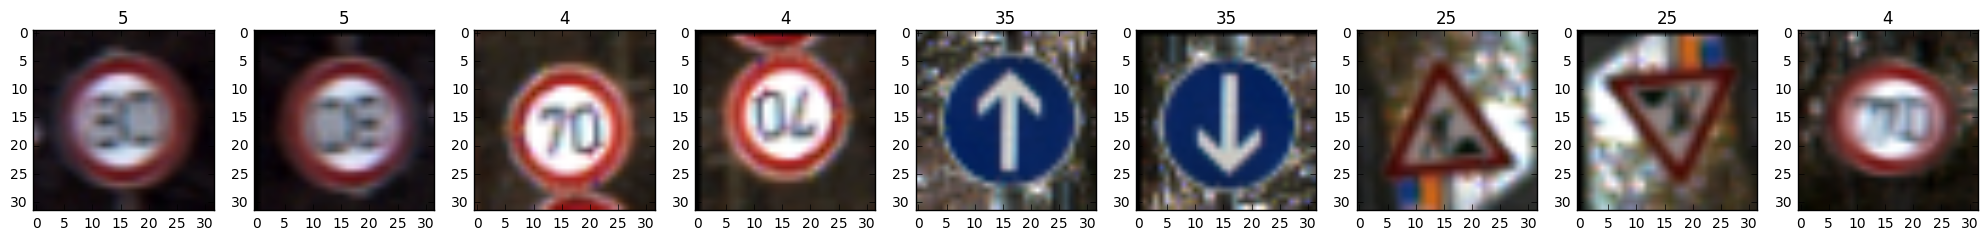

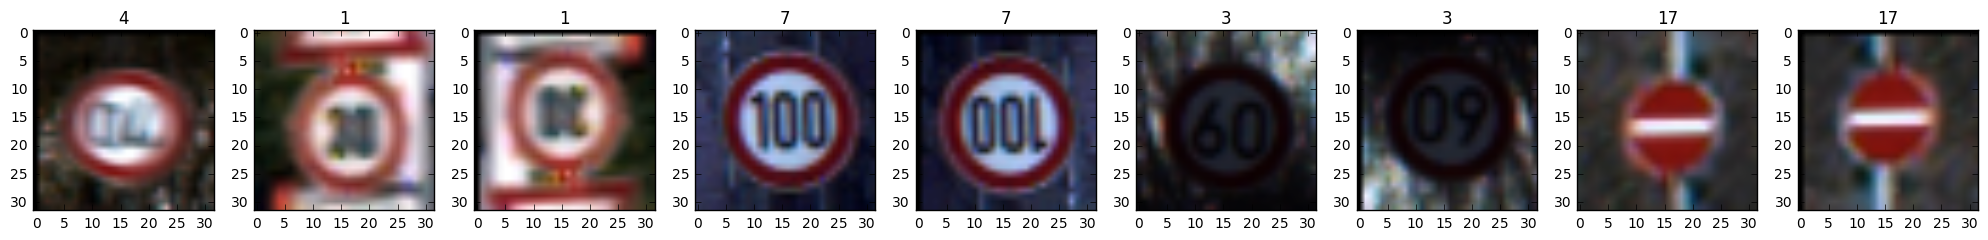

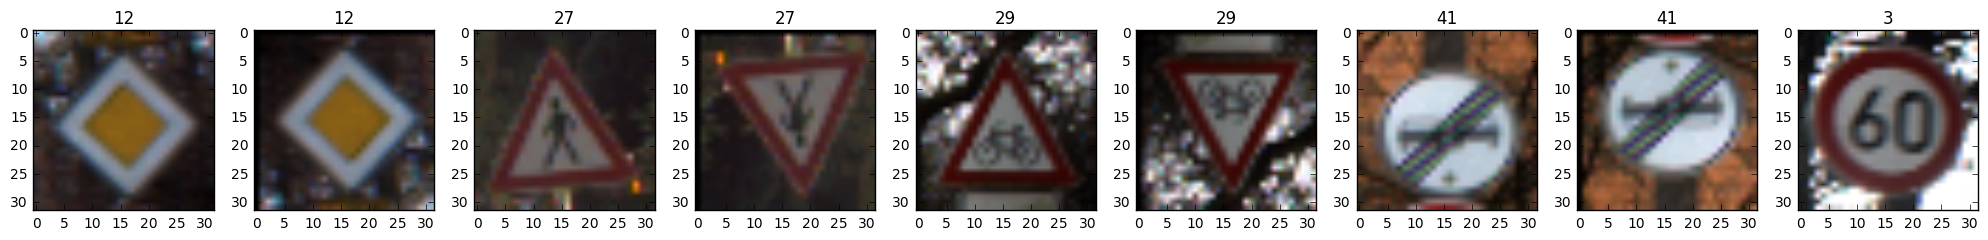

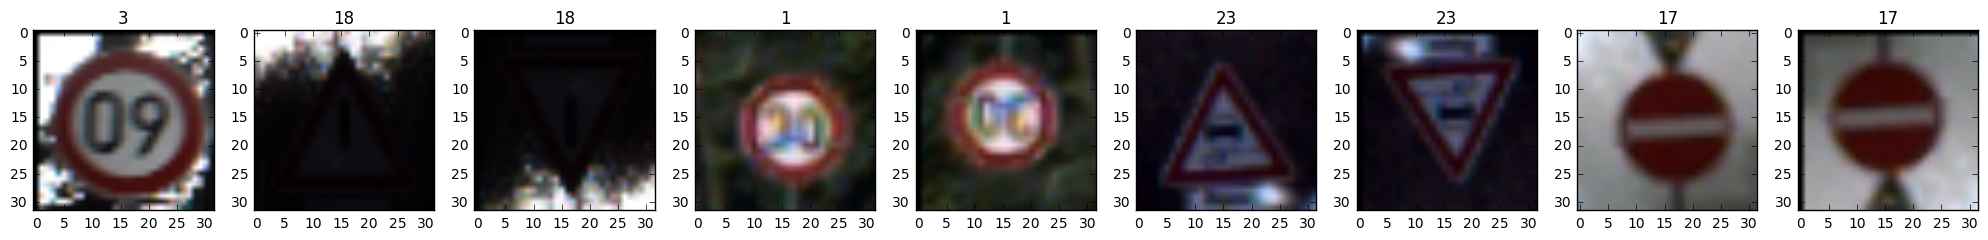

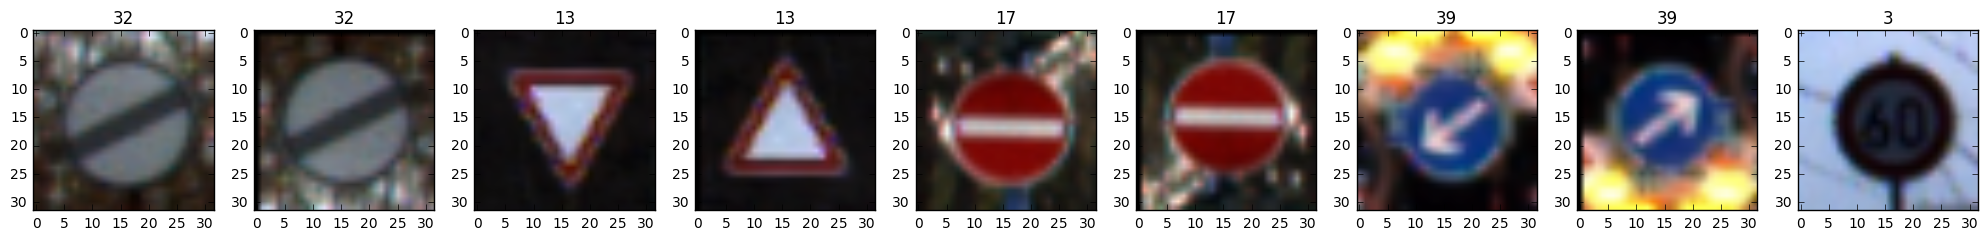

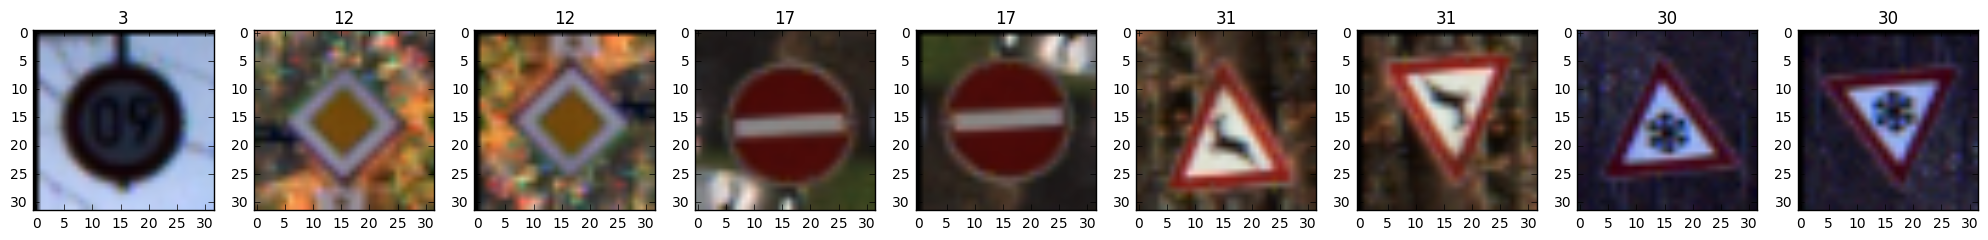

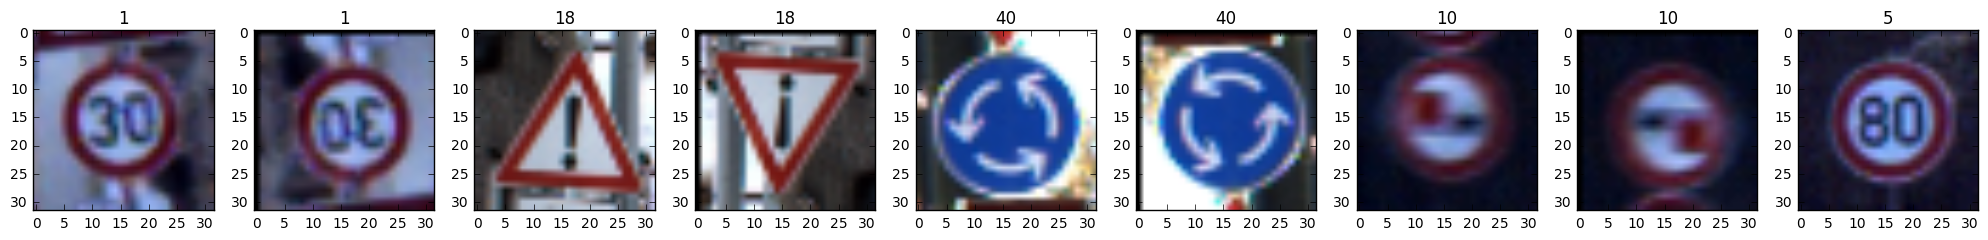

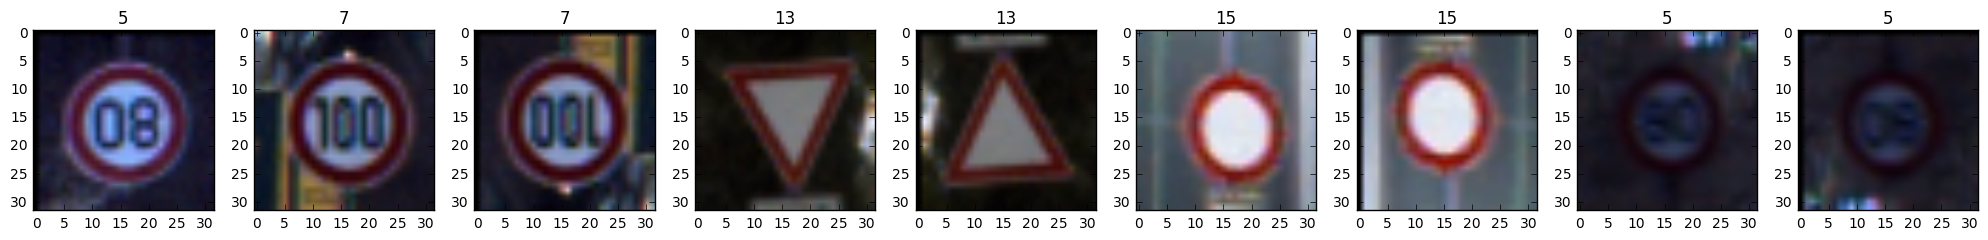

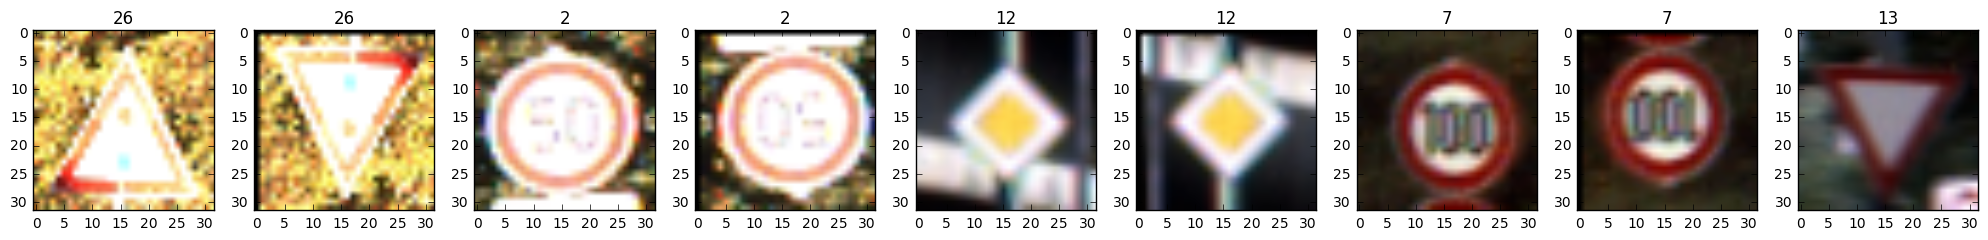

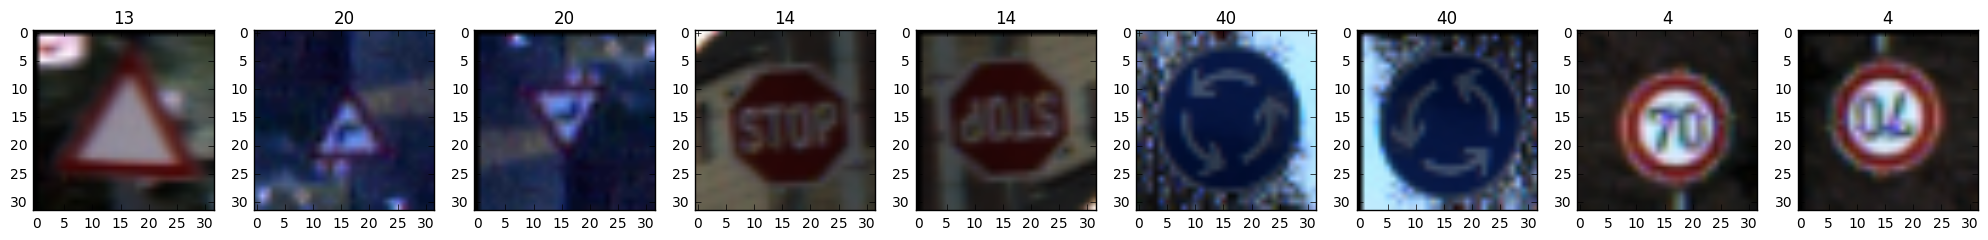

In [133]:
import random

mini_batch_size = 9
for start in range(0, 90, mini_batch_size): 
    fig, axes = plt.subplots(1,mini_batch_size)
    end = start+mini_batch_size
    for i, ((image, ax), label) in enumerate(zip(zip(X_train[start:end], axes), y_train[start:end])):
        ax.set_title(label)
        ax.imshow(image.squeeze())

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [134]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [135]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten


def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    create_weight = lambda shape, name: tf.Variable(tf.truncated_normal(shape=shape, mean=mu, stddev=sigma, name=name))
    create_bias = lambda size, name: tf.Variable(tf.constant(0.1,shape=[size]), name=name)
    conv2d_stride_1x1 = lambda input_x, w: tf.nn.conv2d(input_x, w, strides=[1,1,1,1], padding='SAME')
    
    # Inception 1
    # Sublayer 1 - 32x32x3 -> 1x1 (32,32,32)
    in1_sl1_w = create_weight((1,1,3,32), name='in1_sl1_w')
    in1_sl1_b = create_bias(32, name='in1_sl1_b')
    in1_sl1 = conv2d_stride_1x1(x, in1_sl1_w) + in1_sl1_b
    
    # Sublayer 2 - 32x32x3 -> 1x1 -> 3x3 (30,30,32)
    in1_sl2_1_w = create_weight((1,1,3,16), name='in1_sl2_1_w')
    in1_sl2_1_b = create_bias(16, name='in1_sl2_1_b')
    in1_sl2 = tf.nn.relu(conv2d_stride_1x1(x, in1_sl2_1_w) + in1_sl2_1_b)
    
    in1_sl2_2_w = create_weight((3,3,16,32), name='in1_sl2_2_w')
    in1_sl2_2_b = create_bias(32, name='in1_sl2_2_b')
    in1_sl2 = conv2d_stride_1x1(in1_sl2, in1_sl2_2_w) + in1_sl2_2_b
    
    # Sublayer 3 - 32x32x3 -> 1x1 -> 5x5 (28,28,32)
    in1_sl3_1_w = create_weight((1,1,3,16), name='in1_sl3_1_w')
    in1_sl3_1_b = create_bias(16, name='in1_sl3_1_b')
    in1_sl3 = tf.nn.relu(conv2d_stride_1x1(x, in1_sl3_1_w) + in1_sl3_1_b)
    
    in1_sl3_2_w = create_weight((5,5,16,32), name='in1_sl3_2_w')
    in1_sl3_2_b = create_bias(32, name='in1_sl3_2_b')
    in1_sl3 = conv2d_stride_1x1(in1_sl3, in1_sl3_2_w) + in1_sl3_2_b

    
    # SubLayer 4 - 32x32x3 -> 3x3 maxpool -> 1x1 (30,30,32)
    in1_sl4 = tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')
    in1_sl4_1_w = create_weight((1,1,3,32), name='in1_sl4_1_w')
    in1_sl4_1_b = create_bias(32, name='in1_sl4_1_b')
    in1_sl4 = conv2d_stride_1x1(in1_sl4, in1_sl4_1_w) + in1_sl4_1_b

    # Concatenate sublayers, add depths
    inception1 = tf.nn.relu(tf.concat(3, [in1_sl1,in1_sl2,in1_sl3,in1_sl4]))
    
    # Inception 2 Same as first inception
    # Sublayer 1 - 32,32,128 -> 1x1 (32,32,32)
    in2_sl1_w = create_weight((1,1,128,64), name='in2_sl1_w')
    in2_sl1_b = create_bias(64, name='in2_sl1_b')
    in2_sl1 = conv2d_stride_1x1(inception1, in2_sl1_w) + in2_sl1_b
    
    # Sublayer 2 - 32,32,128 -> 1x1 -> 3x3 (30,30,32)
    in2_sl2_1_w = create_weight((1,1,128,16), name='in2_sl2_1_w')
    in2_sl2_1_b = create_bias(16, name='in2_sl2_1_b')
    in2_sl2 = tf.nn.relu(conv2d_stride_1x1(inception1, in2_sl2_1_w) + in2_sl2_1_b)
    
    in2_sl2_2_w = create_weight((3,3,16,64), name='in2_sl2_2_w')
    in2_sl2_2_b = create_bias(64, name='in2_sl2_2_b')
    in2_sl2 = conv2d_stride_1x1(in2_sl2, in2_sl2_2_w) + in2_sl2_2_b
    
    # Sublayer 3 - 32,32,128 -> 1x1 -> 5x5 (28,28,32)
    in2_sl3_1_w = create_weight((1,1,128,16), name='in2_sl3_1_w')
    in2_sl3_1_b = create_bias(16, name='in2_sl3_1_b')
    in2_sl3 = tf.nn.relu(conv2d_stride_1x1(inception1, in2_sl3_1_w) + in2_sl3_1_b)
    
    in2_sl3_2_w = create_weight((5,5,16,64), name='in2_sl3_2_w')
    in2_sl3_2_b = create_bias(64, name='in2_sl3_2_b')
    in2_sl3 = conv2d_stride_1x1(in2_sl3, in2_sl3_2_w) + in2_sl3_2_b

    # SubLayer 4 - 32,32,128 -> 3x3 maxpool -> 1x1 (30,30,32)
    in2_sl4 = tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')
    in2_sl4_1_w = create_weight((1,1,3,64), name='in2_sl4_1_w')
    in2_sl4_1_b = create_bias(64, name='in2_sl4_1_b')
    in2_sl4 = conv2d_stride_1x1(in2_sl4, in2_sl4_1_w) + in2_sl4_1_b
    
    inception2 = tf.nn.relu(tf.concat(3, [in2_sl1,in2_sl2,in2_sl3,in2_sl4]))
    
    inception2_flat = flatten(inception2)
    
    fc1_W = create_weight((32*32*4*64, 700), name='fc1_W')
    fc1_b = create_bias(700, name='fc1_b')
    fc1   = tf.matmul(inception2_flat, fc1_W) + fc1_b
    fc1   = tf.nn.relu(fc1)
    fc1   = tf.nn.dropout(fc1, keep_prob)
    
    fc2_W = create_weight((700, 43), name='fc2_W')
    fc2_b = create_bias(43, name='fc2_b')
    logits   = tf.matmul(fc1, fc2_W) + fc2_b
    
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [136]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) 
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [137]:
rate = 0.001
EPOCHS = 20
BATCH_SIZE = 128

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [138]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [139]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.064

EPOCH 2 ...
Validation Accuracy = 0.114

EPOCH 3 ...
Validation Accuracy = 0.120

EPOCH 4 ...
Validation Accuracy = 0.150

EPOCH 5 ...
Validation Accuracy = 0.165

EPOCH 6 ...
Validation Accuracy = 0.193

EPOCH 7 ...
Validation Accuracy = 0.269

EPOCH 8 ...
Validation Accuracy = 0.357

EPOCH 9 ...
Validation Accuracy = 0.367

EPOCH 10 ...
Validation Accuracy = 0.519

EPOCH 11 ...
Validation Accuracy = 0.568

EPOCH 12 ...
Validation Accuracy = 0.587

EPOCH 13 ...
Validation Accuracy = 0.572

EPOCH 14 ...
Validation Accuracy = 0.612

EPOCH 15 ...
Validation Accuracy = 0.547

EPOCH 16 ...
Validation Accuracy = 0.688

EPOCH 17 ...
Validation Accuracy = 0.779

EPOCH 18 ...
Validation Accuracy = 0.482

EPOCH 19 ...
Validation Accuracy = 0.477

EPOCH 20 ...
Validation Accuracy = 0.469

Model saved


## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))